In [337]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from datetime import datetime
from sklearn import tree

In [303]:
data = pd.read_csv('data/model/model_pat.csv')

#### Drop PatNum column

In [304]:
data.drop(['PatNum', 'PatStatus'], axis=1, inplace=True)

#### Optional: Drop non-important features

In [307]:
lame_features = ['BalOver90', 'Zip_96073', 'Bal_31_60', 'Zip_96080', 'Bal_61_90','Zip_96099']
reduced = data.drop(lame_features, axis=1)
reducedX = reduced.drop(['churn', 'LastVisit'], axis=1)
reducedy = reduced.churn
reducedX.shape, reducedy.shape

((2402, 19), (2402,))

#### Extract label

In [308]:
X = data.drop(['churn', 'LastVisit'], axis=1)
y = data.churn
X.shape, y.shape

((2402, 25), (2402,))

#### Split data into train and test

In [246]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1921, 25), (481, 25), (1921,), (481,))

In [324]:
rxtrain, rxtest, rytrain, rytest = train_test_split(reducedX, reducedy, test_size = 0.2)
rxtrain.shape, rxtest.shape, rytrain.shape, rytest.shape

((1921, 19), (481, 19), (1921,), (481,))

In [318]:
rf = RandomForestClassifier()
param_grid = { 
     'n_estimators': [100, 200, 300, 400, 500, 750, 1000],
#     'max_features': ['auto', 'sqrt', 'log2', None],
     'min_samples_split' : [2,3,4,5,6,7,8]
#     'criterion' :['gini', 'entropy']
 }

In [326]:
clf = GridSearchCV(rf, param_grid=param_grid, cv=10, verbose=1, scoring='f1')

In [327]:
start = datetime.now()
clf.fit(rxtrain, rytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:  5.8min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 750, 1000]},
             scoring='f1', verbose=1)

0:00:05.852423 minutes of run time.


In [268]:
clf.best_params_

{'min_samples_split': 4, 'n_estimators': 200}

In [269]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=4)
print(np.mean(cross_val_score(rf, xtrain, ytrain, scoring='f1', cv=10, verbose=1, n_jobs=-1)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


0.7857722035805182


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [331]:
rf.fit(xtrain, ytrain)

RandomForestClassifier()

In [332]:
rf.feature_importances_

array([0.02269914, 0.01317285, 0.07750579, 0.00742317, 0.00219071,
       0.00186601, 0.00574834, 0.01098217, 0.02617728, 0.01845674,
       0.10140633, 0.00708003, 0.14904216, 0.16460747, 0.01542979,
       0.00827709, 0.00448455, 0.0016048 , 0.00107425, 0.02149873,
       0.14481897, 0.03182676, 0.09816064, 0.01921536, 0.04525086])

In [272]:
fi = pd.DataFrame(zip(X.columns, rf.feature_importances_))

In [273]:
fi.columns=['features', 'values']

In [274]:
fi_sorted = fi.sort_values('values', ascending=False)

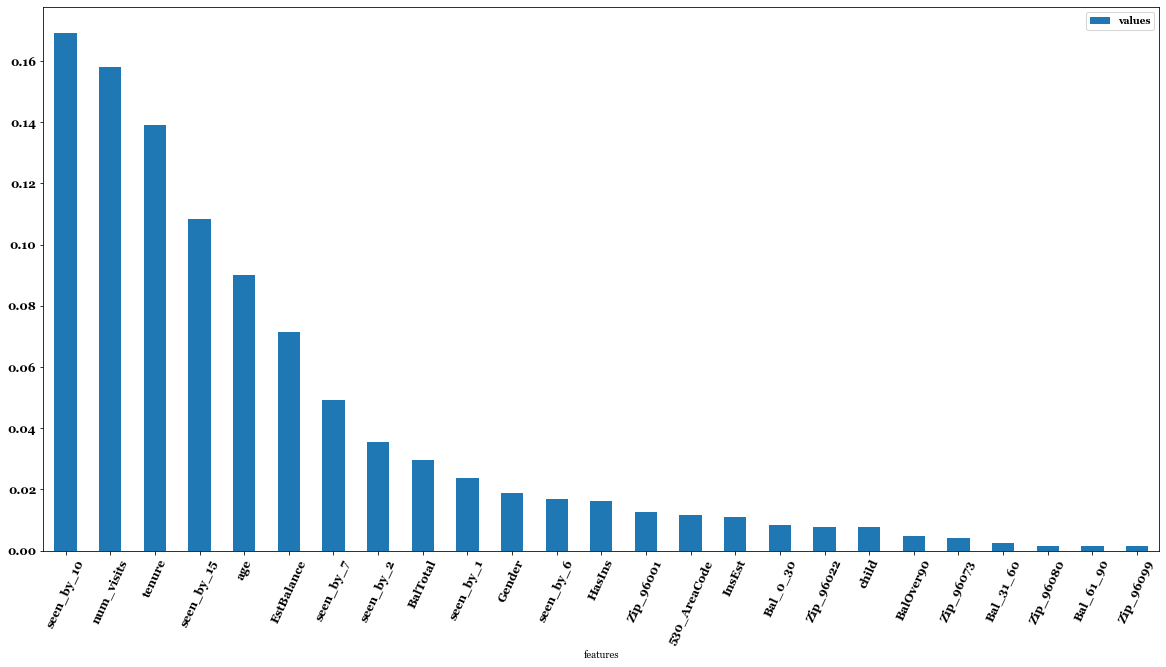

In [275]:
plot = fi_sorted.plot(kind='bar', x='features', y='values')
ticks = plt.xticks(rotation=65)

RandomForestClassifier()

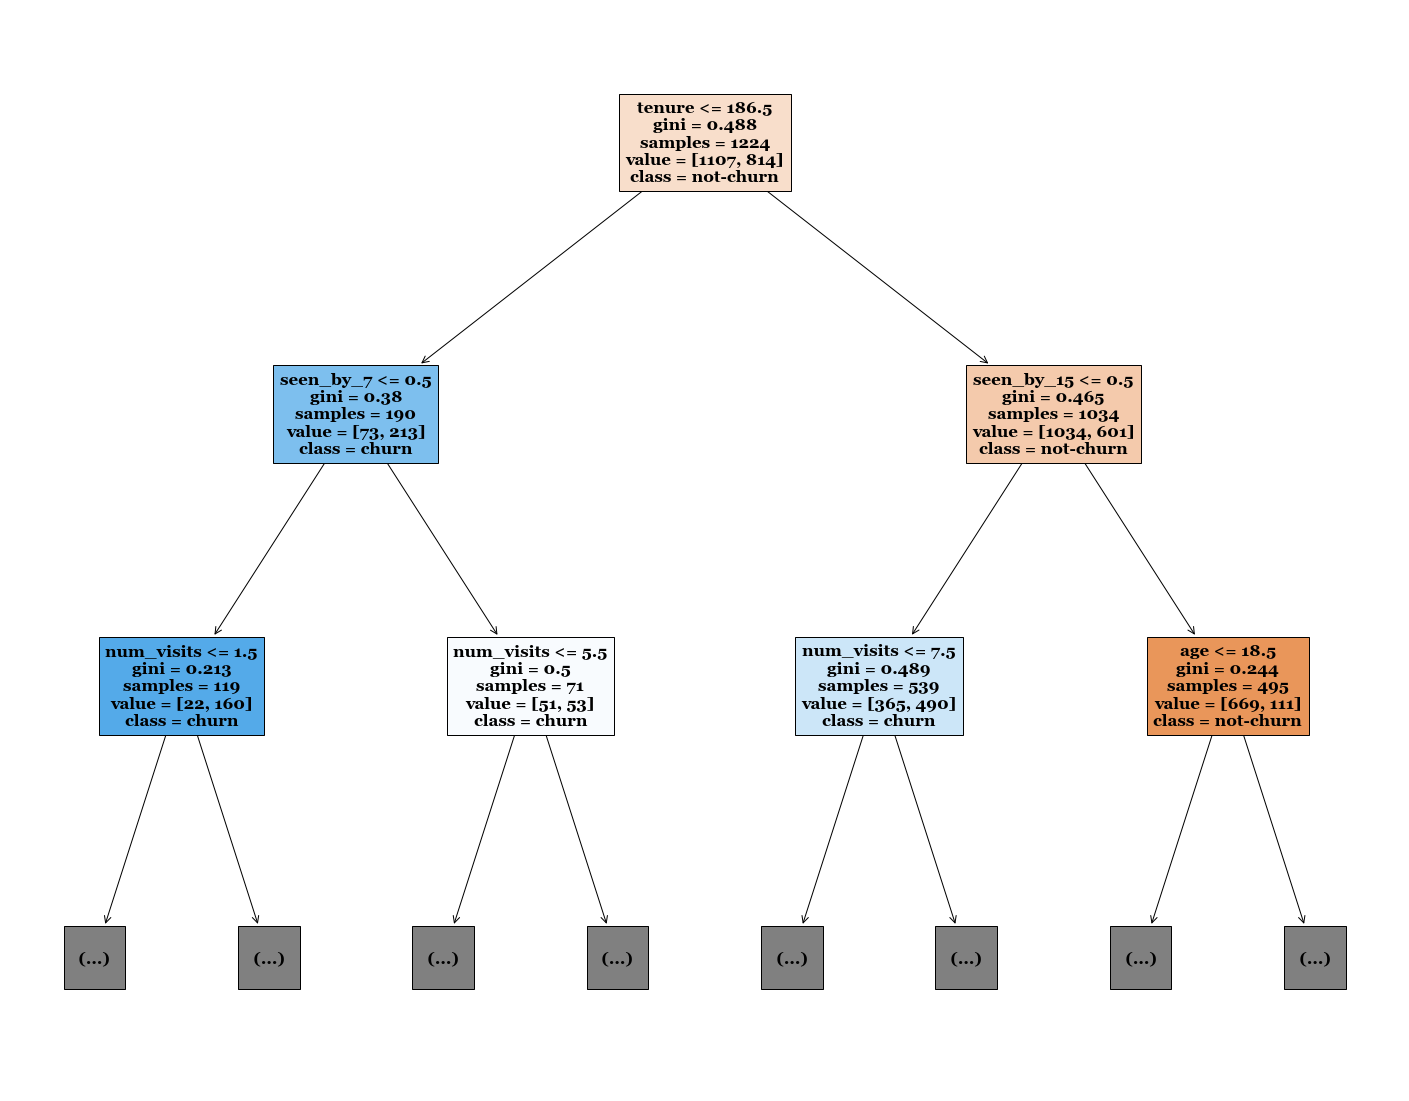

In [334]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(rf.estimators_[1], max_depth=2,
                   feature_names=X.columns,  
                   class_names=['not-churn', 'churn'],
                   filled=True)

In [276]:
preds = rf.predict(xtest)

In [277]:
print(classification_report(ytest, preds, target_names=['Not-churned', 'Churned'] ))

              precision    recall  f1-score   support

 Not-churned       0.84      0.89      0.86       284
     Churned       0.82      0.76      0.79       197

    accuracy                           0.84       481
   macro avg       0.83      0.82      0.83       481
weighted avg       0.84      0.84      0.83       481



In [281]:
threshold = 0.4
predicted_proba = rf.predict_proba(xtest)
predictions = (predicted_proba[:,1] >= threshold).astype('int')
print(classification_report(ytest, predictions, target_names=['Not-churned', 'Churned']))

              precision    recall  f1-score   support

 Not-churned       0.88      0.81      0.85       284
     Churned       0.76      0.85      0.80       197

    accuracy                           0.83       481
   macro avg       0.82      0.83      0.82       481
weighted avg       0.83      0.83      0.83       481



In [157]:
rf.decision_path(xtrain)

(<1921x671812 sparse matrix of type '<class 'numpy.int64'>'
 	with 22415502 stored elements in Compressed Sparse Row format>,
 array([     0,    657,   1334, ..., 670540, 671141, 671812]))

In [257]:
for thresh in np.arange(0.2, 0.5, 0.01):
    threshold = thresh
    predicted_proba = rf.predict_proba(xtest)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')
    print(f'F1 Score at {round(threshold, 2)} prediction threshold: {round(f1_score(ytest, predicted), 2)}')
    tp, fp, fn, tn = confusion_matrix(ytest, predicted).ravel()
    print(f'False Positives = {fp}, False Negatives = {fn}\n\n')

F1 Score at 0.2 prediction threshold: 0.73
False Positives = 131, False Negatives = 9


F1 Score at 0.21 prediction threshold: 0.74
False Positives = 124, False Negatives = 9


F1 Score at 0.22 prediction threshold: 0.75
False Positives = 119, False Negatives = 9


F1 Score at 0.23 prediction threshold: 0.75
False Positives = 114, False Negatives = 9


F1 Score at 0.24 prediction threshold: 0.76
False Positives = 111, False Negatives = 10


F1 Score at 0.25 prediction threshold: 0.76
False Positives = 107, False Negatives = 11


F1 Score at 0.26 prediction threshold: 0.76
False Positives = 104, False Negatives = 12


F1 Score at 0.27 prediction threshold: 0.76
False Positives = 101, False Negatives = 13


F1 Score at 0.28 prediction threshold: 0.76
False Positives = 99, False Negatives = 14


F1 Score at 0.29 prediction threshold: 0.77
False Positives = 93, False Negatives = 15


F1 Score at 0.3 prediction threshold: 0.77
False Positives = 89, False Negatives = 17


F1 Score at 0.31 pr

In [158]:
print(classification_report(ytest, predicted, target_names=['Not-churned', 'Churned'] ))

              precision    recall  f1-score   support

 Not-churned       0.82      0.94      0.88       266
     Churned       0.91      0.74      0.82       215

    accuracy                           0.85       481
   macro avg       0.87      0.84      0.85       481
weighted avg       0.86      0.85      0.85       481



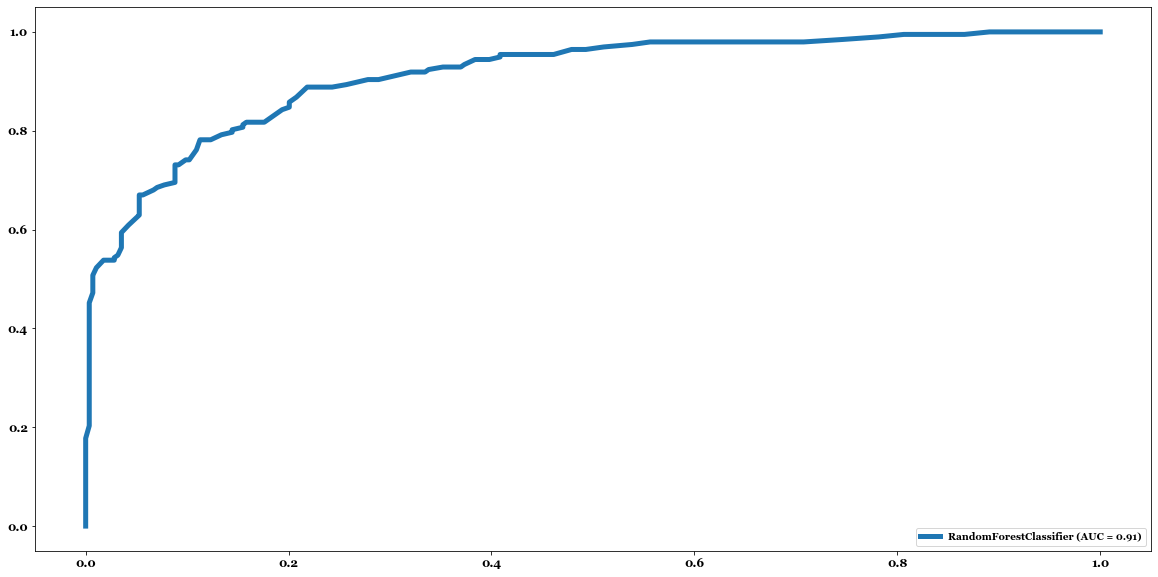

In [339]:
plot_roc_curve(rf, xtest, ytest, lw=5)

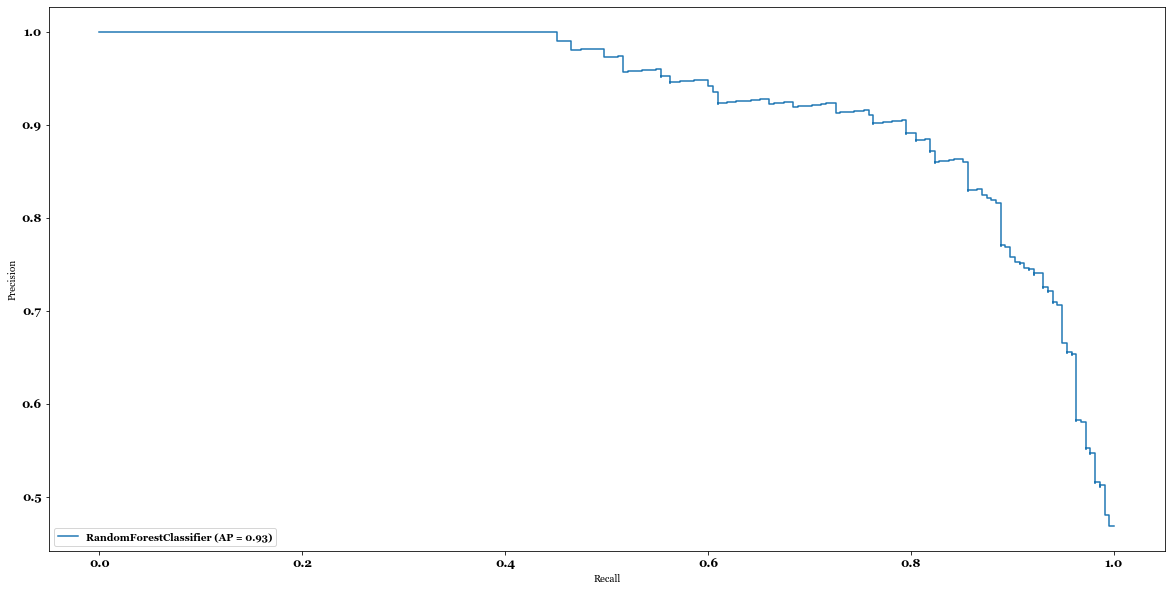

In [188]:
plot_precision_recall_curve(rf, xtest, ytest)

In [210]:
fpr, tpr, threshold = roc_curve(ytest, pos_probs)

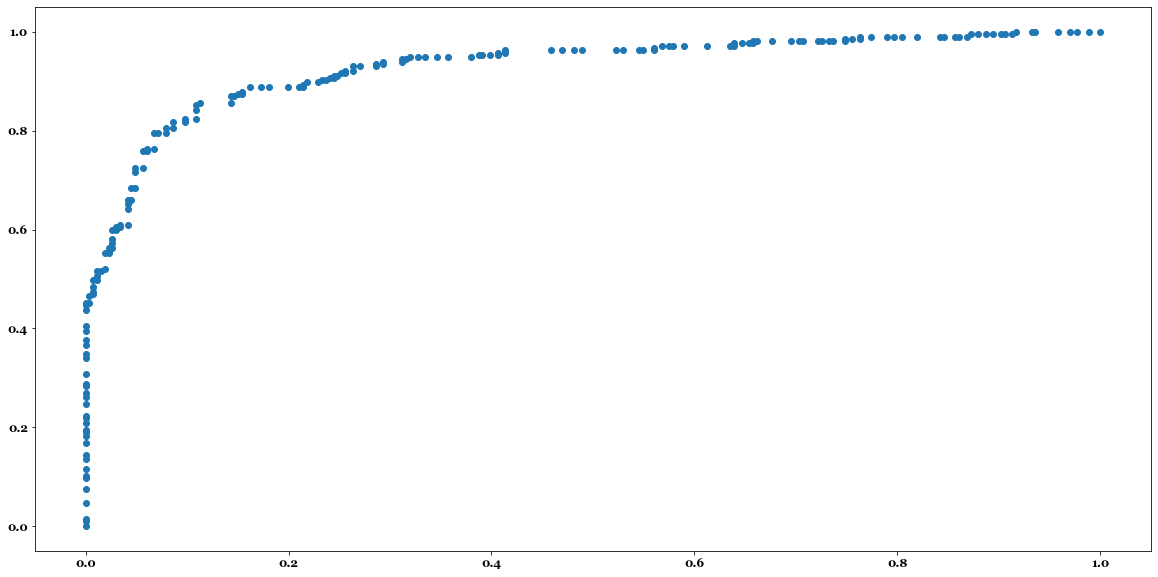

In [214]:
plt.scatter(fpr, tpr)

In [ ]:
plot_roc_curve(rf, xtest, ytest)

In [221]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(cv=10, max_iter=500, solver='liblinear')

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(xtrain)

# transform training data
x_train_norm = norm.transform(xtrain)

# transform testing dataabs
x_test_norm = norm.transform(xtest)

lr.fit(x_train_norm, ytrain)

plot_roc_curve(rf, xtest, ytest)
plot_roc_curve(lr, x_test_norm, ytest)

logits = lr.predict(x_test_norm)

print(classification_report(ytest, logits))

for thresh in np.arange(0.2, 0.5, 0.02):
    threshold = thresh
    predicted_proba = lr.predict_proba(x_test_norm)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')
    print(f'F1 Score at {round(threshold, 2)} prediction threshold: {round(f1_score(ytest, predicted), 2)}')
    tp, fp, fn, tn = confusion_matrix(ytest, predicted).ravel()
    print(f'False Positives = {fp}, False Negatives = {fn}\n\n')

In [235]:
lr.coef_

array([[ -2.53225853,  -0.08390074,  -0.02982175,   1.40332015,
        -21.86563479,  -6.59471061, -10.42638435, -12.61804422,
        -22.12487651,  17.36447612,   0.10867204,   1.01159903,
         -0.22072918,  -1.51973975,  -7.69972223,   0.04300646,
         -0.22650811,  -0.22343696,   0.6845462 ,   1.39906171,
          0.94992835,  -1.61072807,   1.32609515,  -1.3859026 ,
          0.5594619 ,  -0.94833278]])